# Credit Card Fraud Detection with AutoXGB

## Part 2 - Baseline Model: XGBoost with RandomizedSearchCV
___

### Import dependencies and data

In [1]:
# !pip install xgboost --upgrade

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import xgboost as xgb
from xgboost import XGBClassifier, plot_importance

import sklearn.metrics as metrics
from sklearn.model_selection import RandomizedSearchCV

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)

In [3]:
print(xgb.__version__)

1.5.0


If you are running this notebook on Colab (which I did), make sure to upgrade the XGBoost version (default version on Colab is 0.90) using `!pip install xgboost --upgrade`

In [4]:
# Import processed datasets
main_df = pd.read_csv('data/processed/train.csv')
test_df = pd.read_csv('data/processed/test.csv')

In [5]:
main_df.head()

,TX_AMOUNT,TX_DURING_WEEKEND,TX_DURING_NIGHT,CUSTOMER_ID_NB_TX_1DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW,CUSTOMER_ID_NB_TX_7DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW,CUSTOMER_ID_NB_TX_30DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW,TERMINAL_ID_NB_TX_1DAY_WINDOW,TERMINAL_ID_RISK_1DAY_WINDOW,TERMINAL_ID_NB_TX_7DAY_WINDOW,TERMINAL_ID_RISK_7DAY_WINDOW,TERMINAL_ID_NB_TX_30DAY_WINDOW,TERMINAL_ID_RISK_30DAY_WINDOW,TX_FRAUD
0,27.96,0,1,6.0,27.075000,27.0,29.554815,124.0,29.438871,3.0,0.0,13.0,0.0,38.0,0.0,0
1,156.79,0,1,7.0,96.827143,30.0,101.335667,100.0,103.366900,3.0,0.0,9.0,0.0,39.0,0.0,0
2,73.69,1,0,2.0,79.280000,8.0,57.468750,72.0,59.144028,1.0,0.0,9.0,0.0,27.0,0.0,0
3,84.79,0,0,3.0,72.053333,22.0,56.531364,82.0,62.831463,3.0,0.0,6.0,0.0,28.0,0.0,0
4,2.36,0,0,2.0,19.250000,7.0,24.541429,21.0,25.007143,2.0,0.0,2.0,0.0,17.0,0.0,0


### Data Preparation

In [6]:
# Define target variable
target = 'TX_FRAUD'

In [7]:
# View labels
main_df[target].value_counts(dropna=False)

0    136690
1     68345
Name: TX_FRAUD, dtype: int64

In [8]:
# Set X and y datasets
X = main_df.drop(columns=target)
y = main_df[target]

### Run XGBoost Classification

In [9]:
# Set parameter grid
xgb_params = {'max_depth': [3, 5, 6, 8, 9, 10, 11], # Maximum depth of a tree
              'learning_rate': [0.01, 0.1, 0.2, 0.3, 0.5], # Step size shrinkage used in update to prevents overfitting
              'subsample': np.arange(0.4, 1.0, 0.1),
              'colsample_bytree': np.arange(0.3, 1.0, 0.1), # Number of features supplied to a tree
              'colsample_bylevel': np.arange(0.3, 1.0, 0.1),
              'n_estimators': np.arange(100, 600, 100),
              'gamma': np.arange(0, 0.7, 0.1) }

In [12]:
# Create RandomizedSearchCV instance
xgb_grid = RandomizedSearchCV(estimator=XGBClassifier(objective='binary:logistic', 
                                                      tree_method="gpu_hist", # Use GPU
                                                      random_state=42,
                                                      eval_metric='logloss'), 
                              param_distributions=xgb_params, 
                              cv=5, 
                              verbose=2,
                              n_iter=60,
                              scoring='neg_log_loss') 

In [14]:
%%time

# Run XGBoost grid search
xgb_grid.fit(X, y)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV] END colsample_bylevel=0.9000000000000001, colsample_bytree=0.3, gamma=0.4, learning_rate=0.3, max_depth=5, n_estimators=100, subsample=0.5; total time=   1.0s
[CV] END colsample_bylevel=0.9000000000000001, colsample_bytree=0.3, gamma=0.4, learning_rate=0.3, max_depth=5, n_estimators=100, subsample=0.5; total time=   0.9s
[CV] END colsample_bylevel=0.9000000000000001, colsample_bytree=0.3, gamma=0.4, learning_rate=0.3, max_depth=5, n_estimators=100, subsample=0.5; total time=   0.8s
[CV] END colsample_bylevel=0.9000000000000001, colsample_bytree=0.3, gamma=0.4, learning_rate=0.3, max_depth=5, n_estimators=100, subsample=0.5; total time=   0.9s
[CV] END colsample_bylevel=0.9000000000000001, colsample_bytree=0.3, gamma=0.4, learning_rate=0.3, max_depth=5, n_estimators=100, subsample=0.5; total time=   0.8s
[CV] END colsample_bylevel=0.5, colsample_bytree=0.3, gamma=0.2, learning_rate=0.01, max_depth=6, n_estimators=200, su

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           enable_categorical=False,
                                           eval_metric='logloss', gamma=None,
                                           gpu_id=None, importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=na...
                   param_distributions={'colsample_bylevel': array([0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                                        'colsample_bytree': array([0.3, 0.4,

Total time taken to train: 25mins

In [15]:
# Best parameters from RandomizedSearchCV
xgb_grid.best_params_

{'colsample_bylevel': 0.3,
 'colsample_bytree': 0.8000000000000003,
 'gamma': 0.5,
 'learning_rate': 0.2,
 'max_depth': 10,
 'n_estimators': 100,
 'subsample': 0.5}

In [16]:
# Get best XGBoost model (based on best parameters) and predict on test set
xgb_best = xgb_grid.best_estimator_

### Predict on Test Set

In [17]:
# Set X and y datasets
X_test = test_df.drop(columns=target)
y_test = test_df[target]

In [18]:
# Get predictions from best model
preds = xgb_best.predict(X_test)

### Review performance metrics

In [19]:
# Define function to consolidate and display performance metrics
def gen_performance_metrics(y_true, y_preds, model_name, round_to=3):
    accuracy = round(metrics.accuracy_score(y_true, y_preds), round_to)
    f1_score = round(metrics.f1_score(y_true, y_preds), round_to)
    precision = round(metrics.precision_score(y_true, y_preds), round_to)
    avg_precision = round(metrics.average_precision_score(y_true, y_preds), round_to)
    recall = round(metrics.recall_score(y_true, y_preds), round_to)

    df = pd.DataFrame([[model_name, accuracy, f1_score, precision, avg_precision, recall]], 
                        columns=['Model', 'Accuracy', 'F1 Score', 'Precision', 'Average Precision', 'Recall'])
    
    display(df)
    display(metrics.ConfusionMatrixDisplay.from_predictions(y_true, y_preds))

,Model,Accuracy,F1 Score,Precision,Average Precision,Recall
0,XGBoost + RandomizedSearchCV,0.996,0.738,0.795,0.55,0.689


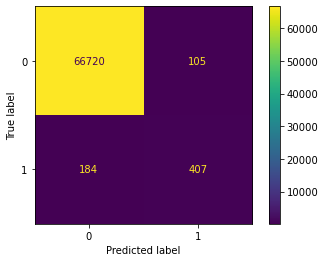

In [20]:
# Show performance assessment
gen_performance_metrics(y_test, preds, 'XGBoost + RandomizedSearchCV')

In [25]:
# Save best model as JSON file
model_filename = 'xgb_baseline.json'
xgb_best.save_model(f'models/{model_filename}')

# Load model
# xgb_best = XGBClassifier()
# xgb_best.load_model(f'models/{model_filename}')